In [1]:
# stopword_corpus_exploration.py
import warnings
warnings.filterwarnings("ignore")
from pathlib import Path
from collections import Counter, defaultdict
import math
import nltk
import pandas as pd
import matplotlib.pyplot as plt
from nltk.corpus import stopwords, brown, gutenberg, webtext, nps_chat, reuters
import numpy as np

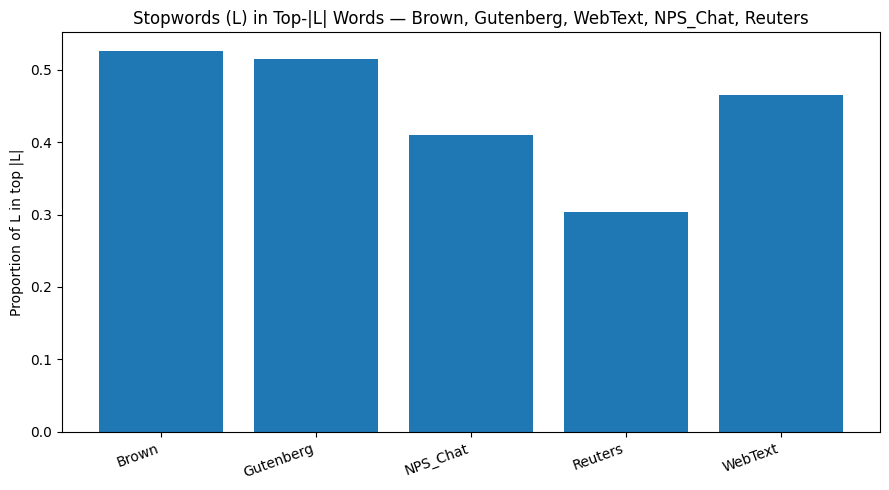

,Corpus,Top_|L|_Unique_Words,Stopwords_in_Top_|L|,Proportion_in_Stoplist_L
0,Brown,198,104,0.525253
1,Gutenberg,198,102,0.515152
2,NPS_Chat,198,81,0.409091
3,Reuters,198,60,0.303030
4,WebText,198,92,0.464646



Consensus Stopword Candidates (appear in at least 4 out of 5 corpora)
the, to, and, a, in, of, it, is, that, for, on, with, not, was, be, he, have, but, are, at, from, this, as, i, they, or, no, all, you, up, one, if, an, will, there, we, my, had, me, what, so, would, about, by, s, do, when, like, out, her, she, were, your, some, his, more, can, has, who, said, been, now, him, man, good, know, after, any, how, its, well, over, then, did, just, than, time, go, them, could, see, into, two, other, here, should, too, only, people, where, first, down, even, make, last, come, think, because, off, say, take, long, still


In [2]:
# task 1
# NOTE: The British National Corpus (BNC) is not analysed here.
#       BNC is very large, slow to iterate. It has taken me more than 30 minutes to process and still can't get the result.
#
# What this section shows:
# 1) Bar plot: proportion of NLTK English stopwords (L) found in the top |L| words of each corpus
# 2) Table: per-corpus counts & proportions
# 3) Consensus stopword candidates: majority across the chosen corpora
# Corpora used: Brown, Gutenberg, WebText, NPS_Chat, Reuters

# Utilities

def _ensure_nltk() -> None:
    """Ensure only the required NLTK resources are present."""
    for pkg, path in [
        ("stopwords", "corpora/stopwords"),
        ("brown", "corpora/brown"),
        ("gutenberg", "corpora/gutenberg"),
        ("webtext", "corpora/webtext"),
        ("nps_chat", "corpora/nps_chat"),
        ("reuters", "corpora/reuters"),
    ]:
        try:
            nltk.data.find(path)
        except LookupError:
            try:
                nltk.download(pkg, quiet=True)
            except Exception:
                pass

def normalize_token(t: str) -> str:
    return t.lower()

def tokenize_words(corpus_words) -> list[str]:
    
    return [w for w in (normalize_token(t) for t in corpus_words) if w.isalpha()]

def get_stopwords() -> tuple[set[str], int]:
    L = set(stopwords.words("english"))
    if not L:
        raise RuntimeError("Stopword list is empty; run nltk.download('stopwords').")
    return L, len(L)


# Data Loading


def get_corpora_def() -> list[tuple[str, list]]:
    return [
        ("Brown", brown.words()),
        ("Gutenberg", gutenberg.words()),
        ("WebText", webtext.words()),
        ("NPS_Chat", nps_chat.words()),
        ("Reuters", reuters.words()),
    ]

def load_corpora_tokens(corpora_def: list[tuple[str, list]]) -> list[tuple[str, list[str]]]:
    available: list[tuple[str, list[str]]] = []
    for name, words in corpora_def:
        try:
            tokens = tokenize_words(words)
            if tokens:
                available.append((name, tokens))
            else:
                print(f"[WARN] '{name}' yielded no tokens; skipping.")
        except LookupError:
            print(f"[WARN] Corpus '{name}' not available. Skipping.")
    if not available:
        raise RuntimeError("No corpora available. Install/download the specified corpora.")
    return available


# Analysis

def compute_topL_stats(
    corpora_tokens: list[tuple[str, list[str]]],
    L: set[str],
    L_size: int
) -> tuple[pd.DataFrame, dict[str, set[str]], dict[str, dict[str, int]]]:
    """
    For each corpus, compute:
      - number of unique words in Top-|L|
      - how many are in L
      - proportion
    Returns (results_df, top_sets, top_rank)
    """
    rows = []
    top_sets: dict[str, set[str]] = {}
    top_rank: dict[str, dict[str, int]] = {}

    for name, tokens in corpora_tokens:
        cnt = Counter(tokens)
        topL = [w for w, _ in cnt.most_common(L_size)]
        top_set = set(topL)
        in_stop = sum(1 for w in topL if w in L)
        prop = in_stop / L_size

        rows.append({
            "Corpus": name,
            "Top_|L|_Unique_Words": len(top_set),
            "Stopwords_in_Top_|L|": in_stop,
            "Proportion_in_Stoplist_L": prop
        })
        top_sets[name] = top_set
        top_rank[name] = {w: i + 1 for i, w in enumerate(topL)} 

    results_df = pd.DataFrame(rows).sort_values("Corpus").reset_index(drop=True)
    return results_df, top_sets, top_rank

# Consensus stopword list (appear in at least 2/3 of corpora)
def compute_consensus_candidates(
    top_sets: dict[str, set[str]],
    top_rank: dict[str, dict[str, int]],
    L_size: int,
    majority: float = 2/3
) -> tuple[list[str], int, int]:
    k = len(top_sets)
    threshold = math.ceil(majority * k)

    appearance_count = Counter()
    for s in top_sets.values():
        appearance_count.update(s)

    consensus = {w for w, c in appearance_count.items() if c >= threshold}

    max_rank = L_size + 1
    rank_sum = defaultdict(int)
    for w in consensus:
        rank_sum[w] = sum(rmap.get(w, max_rank) for rmap in top_rank.values())

    consensus_sorted = sorted(consensus, key=lambda w: (rank_sum[w], -appearance_count[w], w))
    return consensus_sorted, threshold, k


def plot_proportions_bar(results_df: pd.DataFrame) -> None:
    plt.figure(figsize=(9, 5))
    plt.bar(results_df["Corpus"], results_df["Proportion_in_Stoplist_L"])
    plt.ylabel("Proportion of L in top |L|")
    plt.title("Stopwords (L) in Top-|L| Words — Brown, Gutenberg, WebText, NPS_Chat, Reuters")
    plt.xticks(rotation=20, ha="right")
    plt.tight_layout()
    plt.show()

def results_summary_table(results_df: pd.DataFrame, max_rows: int = 50) -> pd.DataFrame:
    return results_df.head(max_rows).reset_index(drop=True)


def print_consensus(consensus_sorted: list[str], threshold: int, k: int, preview: int = 150) -> None:
    print(f"\nConsensus Stopword Candidates (appear in at least {threshold} out of {k} corpora)")
    if len(consensus_sorted) > preview:
        print(", ".join(consensus_sorted[:preview]) + f", ... (+{len(consensus_sorted)-preview} more)")
    else:
        print(", ".join(consensus_sorted))


_ensure_nltk()

# Stopword list
L, L_size = get_stopwords()

# Load corpora tokens
CORPORA_DEF = get_corpora_def()
available = load_corpora_tokens(CORPORA_DEF)

# Compute stats
results_df, top_sets, top_rank = compute_topL_stats(available, L, L_size)

# Plot & Table
plot_proportions_bar(results_df)
table_df = results_summary_table(results_df, max_rows=50)
display(table_df)

# Consensus list
consensus_sorted, threshold, k = compute_consensus_candidates(top_sets, top_rank, L_size, majority=2/3)
print_consensus(consensus_sorted, threshold, k, preview=150)


In [3]:
# Task 2, POS distribution of L + WordNet coverage/synsets 
# Runs on Brown & Reuters.

def ensure_pos_and_wordnet():
    for pkg, path in [
        ("averaged_perceptron_tagger", "taggers/averaged_perceptron_tagger"),
        ("averaged_perceptron_tagger_eng", "taggers/averaged_perceptron_tagger_eng"),
        ("wordnet", "corpora/wordnet"),
        ("universal_tagset", "taggers/universal_tagset"),
    ]:
        try:
            nltk.data.find(path)
        except LookupError:
            try:
                nltk.download(pkg, quiet=True)
            except Exception:
                pass
from nltk.corpus import wordnet as wn

def pos_distribution_for_L(tokens: list[str], stopword_set: set[str]) -> pd.DataFrame:
    """Proportion of each universal POS tag among tokens that are in L."""
    tagged = nltk.pos_tag(tokens, tagset="universal")
    l_tags = [pos for (w, pos) in tagged if w in stopword_set]
    if not l_tags:
        return pd.DataFrame(columns=["POS", "Count", "Proportion"])
    cnt = Counter(l_tags)
    total = sum(cnt.values())
    df = (pd.DataFrame(
            [{"POS": k, "Count": v, "Proportion": v / total} for k, v in cnt.items()]
         )
         .sort_values("Proportion", ascending=False)
         .reset_index(drop=True))
    return df


def run_pos_tables_for_corpora(corpora: list[tuple[str, list]], stopword_set: set[str]) -> dict[str, pd.DataFrame]:
    """Compute POS distribution tables for each corpus."""
    tables = {}
    for name, words in corpora:
        tokens = tokenize_words(words)  # from Task 1
        tables[name] = pos_distribution_for_L(tokens, stopword_set)
    return tables


def wordnet_synset_summary_table(stopword_set: set[str]) -> pd.DataFrame:
    syn_counts = {w: len(wn.synsets(w)) for w in stopword_set}
    counts = np.array(list(syn_counts.values()), dtype=float)

    nonzero = counts[counts > 0]
    if nonzero.size == 0:
        return pd.DataFrame([{
            "L_size": len(stopword_set),
            "words_with_entry": 0,
            "coverage_proportion": 0.0,
            "avg_synsets": 0.0,
            "std_synsets": 0.0,
            "min_synsets": 0,
            "max_synsets": 0,
        }])

    return pd.DataFrame([{
        "L_size": len(stopword_set),
        "words_with_entry": int(nonzero.size),
        "coverage_proportion": float(nonzero.size / len(stopword_set)),
        "avg_synsets": float(np.mean(nonzero)),
        "std_synsets": float(np.std(nonzero, ddof=1)) if nonzero.size > 1 else 0.0,
        "min_synsets": int(np.min(nonzero)),
        "max_synsets": int(np.max(nonzero)),
    }])


# Usage
ensure_pos_and_wordnet()

# POS proportions among L for 2 corpora
CORPORA = [
    ("Brown", brown.words()),
    ("Reuters", reuters.words()),
]
pos_tables = run_pos_tables_for_corpora(CORPORA, L)
for name, df in pos_tables.items():
    print(f"\nPOS distribution among stopwords (L) — {name}")
    display(df)

# Proportion of L with WordNet entry + synset stats (avg, std, min, max)

summary_df = wordnet_synset_summary_table(L)

# A generic function to show tables, with possible custom formats
def show_table(df: pd.DataFrame, title: str, fmt: dict | None = None, footnote: str | None = None):
    default_fmt = {"avg_cos": "{:.3f}", "std_cos": "{:.3f}",
                   "min_cos": "{:.3f}", "max_cos": "{:.3f}"}
    if fmt:
        default_fmt.update(fmt)

    # Use custom footnote if provided; otherwise use the default text
    footnote_text = footnote or "avg = average; std = standard deviation; min = minimum; max = maximum"
    caption_html = (
        title
        + "<br><span style='font-size:0.9em'>"
        + footnote_text
        + "</span>"
    )

    display(
        df.style
          .set_caption(caption_html)
          .hide(axis="index")
          .set_table_styles([{"selector": "caption",
                              "props": [("caption-side", "top"),
                                        ("text-align", "left")]}])
          .format(default_fmt)
    )



show_table(summary_df, "WordNet Synset Summary for Stopword List L", 
           fmt = {"coverage_proportion":"{:.3f}","avg_synsets":"{:.3f}","std_synsets":"{:.3f}"})


POS distribution among stopwords (L) — Brown


,POS,Count,Proportion
0,ADP,127699,0.270292
1,DET,123443,0.261283
2,PRON,60137,0.127288
3,VERB,58248,0.123289
4,CONJ,37669,0.079731
5,PRT,29979,0.063454
6,ADV,23879,0.050543
7,ADJ,7829,0.016571
8,NOUN,3564,0.007544
9,X,1,0.000002



POS distribution among stopwords (L) — Reuters


,POS,Count,Proportion
0,ADP,147652,0.324065
1,DET,116421,0.255519
2,VERB,52888,0.116078
3,PRT,39480,0.086650
4,PRON,32656,0.071673
5,CONJ,32616,0.071585
6,ADV,13333,0.029263
7,ADJ,11975,0.026283
8,NOUN,8530,0.018722
9,X,71,0.000156


L_size,words_with_entry,coverage_proportion,avg_synsets,std_synsets,min_synsets,max_synsets
198,88,0.444,6.807,5.719,1,26


In [4]:
# Task 3, Wu–Palmer similarity over L (WordNet entries only), with derivational noun mapping


def candidate_noun_synsets(word: str) -> list:
    """Return noun synsets for a word; if none, use derivationally related noun synsets."""
    sns = wn.synsets(word, pos=wn.NOUN)
    if sns:
        return sns

    noun_names = set()
    for s in wn.synsets(word):
        for lem in s.lemmas():
            for rel in lem.derivationally_related_forms():
                syn = rel.synset()
                if syn.pos() == 'n':
                    noun_names.add(rel.name())

    # expand lemma names to their noun synsets
    noun_synsets = []
    for name in noun_names:
        noun_synsets.extend(wn.synsets(name, pos=wn.NOUN))
    return noun_synsets


def wup_similarity_max_over_candidates(w1: str, w2: str) -> float | None:
    """Max Wu–Palmer similarity over all candidate noun synset pairs for (w1, w2)."""
    s1 = candidate_noun_synsets(w1)
    s2 = candidate_noun_synsets(w2)
    if not s1 or not s2:
        return None

    best = None
    for a in s1:
        for b in s2:
            sim = a.wup_similarity(b)
            if sim is not None:
                best = sim if best is None else max(best, sim)
    return best


def wup_summary_over_L(stopword_set: set[str]) -> pd.DataFrame:
    # Words in L with any WordNet entry
    words = [w for w in stopword_set if wn.synsets(w)]
    words = sorted(set(words))
    n = len(words)

    # Precompute candidate sets; drop words that still have no noun candidates
    cand = {w: candidate_noun_synsets(w) for w in words}
    words_final = [w for w in words if cand[w]]
    m = len(words_final)

    sims = []
    for i in range(m):
        wi = words_final[i]
        for j in range(i + 1, m):
            wj = words_final[j]
            sim = wup_similarity_max_over_candidates(wi, wj)
            if sim is not None and np.isfinite(sim):
                sims.append(sim)

    if not sims:
        return pd.DataFrame([{
            "L_size": len(stopword_set),
            "words_with_WordNet_entry": len(words),
            "words_used_after_noun_mapping": m,
            "pair_count": 0,
            "avg_wup": 0.0,
            "std_wup": 0.0,
            "min_wup": 0.0,
            "max_wup": 0.0,
        }])

    sims = np.array(sims, dtype=float)
    return pd.DataFrame([{
        "L_size": len(stopword_set),
        "words_with_WordNet_entry": len(words),
        "words_used_after_noun_mapping": m,
        "pair_count": int(len(sims)),
        "avg_wup": float(np.mean(sims)),
        "std_wup": float(np.std(sims, ddof=1)) if len(sims) > 1 else 0.0,
        "min_wup": float(np.min(sims)),
        "max_wup": float(np.max(sims)),
    }])


wup_summary_df = wup_summary_over_L(L)

show_table(wup_summary_df, "Wu–Palmer Similarity Summary for Stopword List L",
          {"avg_wup":"{:.3f}", "std_wup":"{:.3f}", "min_wup":"{:.3f}", "max_wup":"{:.3f}"})

L_size,words_with_WordNet_entry,words_used_after_noun_mapping,pair_count,avg_wup,std_wup,min_wup,max_wup
198,88,65,2080,0.429,0.211,0.100,1.000


In [5]:
# Task 4, redo Task 2 & 3 for two non-English languages (Spanish, French)
# POS for similarity: NOUN
# Similar logic as task 2 and task 3 with some modifications.
# Using WordNet/OMW for cross-lingual synsets + Wu–Palmer.
# WordNet only has n/v/a/r; So “POS distribution” here counts presence of content POS only.

# Ensure multilingual resources
for pkg, path in [
    ("omw-1.4", "corpora/omw-1.4"),
]:
    try:
        nltk.data.find(path)
    except LookupError:
        nltk.download(pkg, quiet=True)

# ---Helpers---

def get_stopwords_lang(lang_name: str) -> set[str]:
    return set(stopwords.words(lang_name))

# WordNet based
def pos_distribution_over_L_wordnet_lang(stoplist: set[str], lang_code: str) -> pd.DataFrame:
    """Word-level POS presence over L using WordNet in that language."""
    pos_map = {"n": "NOUN", "v": "VERB", "a": "ADJ", "s": "ADJ", "r": "ADV"}
    words_with_entry = []
    pos_flags = {p: set() for p in ["NOUN", "VERB", "ADJ", "ADV"]}

    for w in stoplist:
        syns = wn.synsets(w, lang=lang_code)
        if not syns:
            continue
        words_with_entry.append(w)
        for s in syns:
            tag = pos_map.get(s.pos())
            if tag:
                pos_flags[tag].add(w)

    if not words_with_entry:
        return pd.DataFrame(columns=["POS", "Count", "Proportion"])

    total = len(set(words_with_entry))
    rows = []
    for tag in ["NOUN", "VERB", "ADJ", "ADV"]:
        c = len(pos_flags[tag])
        rows.append({"POS": tag, "Count": c, "Proportion": c / total})
    return pd.DataFrame(rows).sort_values("Proportion", ascending=False).reset_index(drop=True)

def candidate_synsets_lang(word: str, lang_code: str, pos) -> list:
    return wn.synsets(word, lang=lang_code, pos=pos)

def wup_similarity_max_over_candidates_lang(w1: str, w2: str, lang_code: str, pos) -> float | None:
    s1 = candidate_synsets_lang(w1, lang_code, pos)
    s2 = candidate_synsets_lang(w2, lang_code, pos)
    if not s1 or not s2:
        return None
    best = None
    for a in s1:
        for b in s2:
            sim = a.wup_similarity(b)
            if sim is not None:
                best = sim if best is None else max(best, sim)
    return best

def wordnet_synset_summary_table_lang(stoplist: set[str], lang_code: str) -> pd.DataFrame:
    syn_counts_any = {w: len(wn.synsets(w, lang=lang_code)) for w in stoplist}
    counts = np.array(list(syn_counts_any.values()), dtype=float)
    words_with_entry = int(np.sum(counts > 0))
    nonzero = counts[counts > 0]

    if nonzero.size == 0:
        return pd.DataFrame([{
            "L_size": len(stoplist),
            "words_with_WordNet_entry": 0,
            "coverage_proportion": 0.0,
            "avg_synsets": 0.0,
            "std_synsets": 0.0,
            "min_synsets": 0,
            "max_synsets": 0,
        }])

    return pd.DataFrame([{
        "L_size": len(stoplist),
        "words_with_WordNet_entry": words_with_entry,        
        "coverage_proportion": float(words_with_entry / len(stoplist)),
        "avg_synsets": float(np.mean(nonzero)),
        "std_synsets": float(np.std(nonzero, ddof=1)) if nonzero.size > 1 else 0.0,
        "min_synsets": int(np.min(nonzero)),
        "max_synsets": int(np.max(nonzero)),
    }])

def wup_summary_over_stoplist_lang(stoplist: set[str], lang_code: str, pos) -> pd.DataFrame:
    L_size = len(stoplist)
    words_any = sorted(w for w in stoplist if wn.synsets(w, lang=lang_code))             
    words_pos = sorted(w for w in stoplist if candidate_synsets_lang(w, lang_code, pos))

    sims = []
    m = len(words_pos)
    for i in range(m):
        wi = words_pos[i]
        for j in range(i + 1, m):
            wj = words_pos[j]
            sim = wup_similarity_max_over_candidates_lang(wi, wj, lang_code, pos)
            if sim is not None and np.isfinite(sim):
                sims.append(sim)

    if not sims:
        return pd.DataFrame([{
            "L_size": L_size,
            "words_with_WordNet_entry": len(words_any),
            "words_used_after_noun_mapping": len(words_pos),
            "avg_wup": 0.0,
            "std_wup": 0.0,
            "min_wup": 0.0,
            "max_wup": 0.0,
        }])

    sims = np.array(sims, dtype=float)
    return pd.DataFrame([{
        "L_size": L_size,
        "words_with_WordNet_entry": len(words_any),
        "words_used_after_noun_mapping": len(words_pos),
        "avg_wup": float(np.mean(sims)),
        "std_wup": float(np.std(sims, ddof=1)) if len(sims) > 1 else 0.0,
        "min_wup": float(np.min(sims)),
        "max_wup": float(np.max(sims)),
    }])

# Configure languages and POS
LANGS = [
    ("spanish", "spa", "Spanish"),
    ("french",  "fra", "French"),
]
POS_CHOSEN = wn.NOUN

# POS distribution
pos_tables_task4 = {}
for sw_name, omw_code, label in LANGS:
    L_lang = get_stopwords_lang(sw_name)
    pos_tables_task4[label] = pos_distribution_over_L_wordnet_lang(L_lang, omw_code)

syn_rows = []
for sw_name, omw_code, label in LANGS:
    L_lang = get_stopwords_lang(sw_name)
    df_syn = wordnet_synset_summary_table_lang(L_lang, omw_code)
    df_syn.insert(0, "language", label)
    syn_rows.append(df_syn)
task4_syn_df = pd.concat(syn_rows, ignore_index=True)

# WUP summary
rows = []
for sw_name, omw_code, label in LANGS:
    L_lang = get_stopwords_lang(sw_name)
    summ = wup_summary_over_stoplist_lang(L_lang, omw_code, POS_CHOSEN)
    summ.insert(0, "language", label)
    summ.insert(1, "pos", "NOUN")
    rows.append(summ)
task4_wup_df = pd.concat(rows, ignore_index=True)


# --------------------------------------------------
# Display Tables
# uncomment the line beloe if you want to chekc POS distribution
"""for label, df in pos_tables_task4.items():
    print(f"\nPOS distribution over L (WordNet based) — {label}")
    display(df)"""

show_table(task4_syn_df, "WordNet Synset Summary for Stopword List L (Non-English)",
           {"coverage_proportion":"{:.3f}", "avg_synsets":"{:.3f}", "std_synsets":"{:.3f}"})
print()
show_table(task4_wup_df, "Wu–Palmer Similarity Summary over Stopword Lists (Non-English)",
          {"avg_wup":"{:.3f}", "std_wup":"{:.3f}", "min_wup":"{:.3f}", "max_wup":"{:.3f}"})

language,L_size,words_with_WordNet_entry,coverage_proportion,avg_synsets,std_synsets,min_synsets,max_synsets
Spanish,313,30,0.096,2.000,1.965,1,10
French,157,52,0.331,4.577,6.412,1,34


language,pos,L_size,words_with_WordNet_entry,words_used_after_noun_mapping,avg_wup,std_wup,min_wup,max_wup
Spanish,NOUN,313,30,22,0.289,0.168,0.095,0.889
French,NOUN,157,52,46,0.412,0.215,0.077,1.000


In [6]:
# Task 5, Translate non-English stoplists to English
# Reuses:
#   - ensure_pos_and_wordnet (Task 2)
#   - pos_distribution_for_L (Task 2)
#   - wordnet_synset_summary_table (Task 2)
#   - wup_summary_over_L (Task 3)


ensure_pos_and_wordnet()

# Translator
def translate_list_to_en(words: list[str], src_code: str) -> list[str]:
    try:
        from deep_translator import GoogleTranslator
        translator = GoogleTranslator(source=src_code, target="en")
        out = []
        for w in words:
            try:
                t = translator.translate(w)
                if not t:
                    continue
                tok = t.split()[0].lower()
                if tok.isalpha():
                    out.append(tok)
            except Exception:
                continue
        return out
    except Exception:
        print(f"[WARN] deep_translator not available; using identity for src='{src_code}'.")
        return [w.lower() for w in words if w.isalpha()]
        

# Simple translation cache
# Since the translation process is slow, here we will use a simple cache to speed up the process.
from pathlib import Path

TRANSLATION_CACHE_DIR = Path("translations_cache")
TRANSLATION_CACHE_DIR.mkdir(parents=True, exist_ok=True)

def save_translation(lang_name: str, words_en: list[str]) -> Path:
    p = TRANSLATION_CACHE_DIR / f"{lang_name}_to_en.txt"
    uniq = sorted(set(w.strip().lower() for w in words_en if w.strip()))
    p.write_text("\n".join(uniq), encoding="utf-8")
    return p

def load_translation(lang_name: str) -> list[str] | None:
    """Load cached translation if present, else None."""
    p = TRANSLATION_CACHE_DIR / f"{lang_name}_to_en.txt"
    if p.exists():
        return [line.strip() for line in p.read_text(encoding="utf-8").splitlines() if line.strip()]
    return None

def get_translated_stoplist_cached(lang_name: str, src_code: str) -> list[str]:
    """
    Return the translated-to-English stoplist for `lang_name`.
    If cached, load from disk; else translate once and cache.
    """
    cached = load_translation(lang_name)
    if cached is not None:
        return cached
    translated = translate_list_to_en(sorted(set(stopwords.words(lang_name))), src_code)
    save_translation(lang_name, translated)
    return translated



def pos_distribution_for_wordlist_en(words_en: list[str]) -> pd.DataFrame:
    uniq = sorted(set(words_en))
    return pos_distribution_for_L(tokens=uniq, stopword_set=set(uniq))

# Pipeline for a language: translate -> POS distribution (EN) -> Synset Summary -> WUP Summary
def task5_for_language(lang_name: str, src_code: str):
    
    uniq_en = sorted(set(get_translated_stoplist_cached(lang_name, src_code)))

    # POS distribution
    pos_df = pos_distribution_for_wordlist_en(uniq_en)

    # ordNet synset summary
    syn_df = wordnet_synset_summary_table(set(uniq_en))
    syn_df.insert(0, "language", lang_name.capitalize())

    # Wu–Palmer summary
    wup_df = wup_summary_over_L(set(uniq_en))
    wup_df.insert(0, "language", lang_name.capitalize())

    return pos_df, syn_df, wup_df

# Choose languages and run
LANGS = [
    ("spanish", "es"),
    ("french",  "fr"),
]

pos_tables_t5 = {}
syn_rows = []
wup_rows = []

for lang_name, src_code in LANGS:
    pos_df, syn_df, wup_df = task5_for_language(lang_name, src_code)
    pos_tables_t5[lang_name.capitalize()] = pos_df
    syn_rows.append(syn_df)
    wup_rows.append(wup_df)

task5_syn_df = pd.concat(syn_rows, ignore_index=True)
task5_wup_df = pd.concat(wup_rows, ignore_index=True)

# Display
# uncomment the line below if you want to chekc POS distribution
"""for label, df in pos_tables_t5.items():
    print(f"\nPOS distribution over translated stoplist (English tagging) — {label}")
    display(df)"""


show_table(task5_syn_df, "WordNet Synset Summary for Translated Stopword Lists (to English)",
           {"coverage_proportion":"{:.3f}", "avg_synsets":"{:.3f}", "std_synsets":"{:.3f}"})
print()
show_table(task5_wup_df, "Wu–Palmer Similarity Summary for Translated Stopword Lists (English WordNet)",
          {"avg_wup":"{:.3f}", "std_wup":"{:.3f}", "min_wup":"{:.3f}", "max_wup":"{:.3f}"})

language,L_size,words_with_entry,coverage_proportion,avg_synsets,std_synsets,min_synsets,max_synsets
Spanish,93,60,0.645,8.833,8.458,1,47
French,72,49,0.681,7.163,5.963,1,20


language,L_size,words_with_WordNet_entry,words_used_after_noun_mapping,pair_count,avg_wup,std_wup,min_wup,max_wup
Spanish,93,60,47,1081,0.470,0.219,0.100,1.000
French,72,49,44,946,0.477,0.233,0.105,1.000


In [7]:
# Task 6, Cosine similarity of stopwords (L) with W2V GoogleNews, FastText wiki-subwords, and BERT-base
import gensim.downloader as api
import torch
from transformers import AutoTokenizer, AutoModel

# Cosine summary
def cosine_summary(embeddings: np.ndarray) -> pd.DataFrame:
    n = embeddings.shape[0]
    if n < 2:
        return pd.DataFrame([{
            "words_used": n,
            "pair_count": 0,
            "avg_cos": 0.0, "std_cos": 0.0, "min_cos": 0.0, "max_cos": 0.0
        }])

    norms = np.linalg.norm(embeddings, axis=1, keepdims=True)
    norms[norms == 0] = 1e-8
    X = embeddings / norms

    S = np.dot(X, X.T)
    iu = np.triu_indices(n, k=1)
    sims = S[iu]

    return pd.DataFrame([{
        "words_used": int(n),
        "pair_count": int(sims.size),
        "avg_cos": float(np.mean(sims)),
        "std_cos": float(np.std(sims, ddof=1)) if sims.size > 1 else 0.0,
        "min_cos": float(np.min(sims)),
        "max_cos": float(np.max(sims)),
    }])

# Word2Vec: GoogleNews
def embeddings_w2v_google(L: set[str]) -> np.ndarray:
    kv = api.load("word2vec-google-news-300")
    words = [w for w in sorted(L) if w in kv.key_to_index]
    return np.vstack([kv[w] for w in words]) if words else np.zeros((0,1))

# FastText: wiki-news-subwords-300
def embeddings_fasttext_wiki_subword(L: set[str]) -> np.ndarray:
    kv = api.load("fasttext-wiki-news-subwords-300")
    vecs = []
    for w in sorted(L):
        w_try = w.replace("’", "'")
        if w_try in kv.key_to_index:
            vecs.append(kv.get_vector(w_try))
        else:
            w_noapos = w_try.replace("'", "")
            if w_noapos in kv.key_to_index:
                vecs.append(kv.get_vector(w_noapos))
    return np.vstack(vecs) if vecs else np.zeros((0,1))


# BERT-base
def embeddings_bert(L: set[str], model_name: str = "bert-base-uncased", batch_size: int = 64) -> np.ndarray:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name).to(device)
    model.eval()
    words = sorted(L)
    all_vecs = []
    with torch.no_grad():
        for i in range(0, len(words), batch_size):
            batch = words[i:i+batch_size]
            enc = tokenizer(batch, padding=True, truncation=True, return_tensors="pt")
            enc = {k: v.to(device) for k, v in enc.items()}
            out = model(**enc).last_hidden_state
            for b in range(len(batch)):
                mask = enc["attention_mask"][b].bool()
                token_vecs = out[b, mask, :]
                if token_vecs.size(0) >= 2:
                    token_vecs = token_vecs[1:-1]
                if token_vecs.size(0) == 0:
                    continue
                all_vecs.append(token_vecs.mean(dim=0).cpu().numpy())
    return np.vstack(all_vecs) if all_vecs else np.zeros((0,1))


# Generic function to compute cosine-similarity summaries for a word list with chosen models
def run_embedding(words, models: dict, language_label: str = "") -> pd.DataFrame:
    results = []
    uniq = sorted(set(words))

    # Word2Vec (GoogleNews)
    if models.get("w2v"):
        mat = embeddings_w2v_google(set(uniq))
        summ = cosine_summary(mat)
        if language_label: summ.insert(0, "language", language_label)
        summ.insert(0 if not language_label else 1, "model", "word2vec-google-news-300")
        results.append(summ)

    # FastText (wiki-news-subwords-300)
    if models.get("ft"):
        mat = embeddings_fasttext_wiki_subword(set(uniq))
        summ = cosine_summary(mat)
        if language_label: summ.insert(0, "language", language_label)
        summ.insert(0 if not language_label else 1, "model", "fasttext-wiki-news-subwords-300")
        results.append(summ)

    # BERT (name provided in suite["bert"])
    if models.get("bert"):
        bert_name = models["bert"]
        batch = models.get("batch_size", 64)
        mat = embeddings_bert(set(uniq), model_name=bert_name, batch_size=batch)
        summ = cosine_summary(mat)
        if language_label: summ.insert(0, "language", language_label)
        summ.insert(0 if not language_label else 1, "model", bert_name)
        results.append(summ)

    return pd.concat(results, ignore_index=True) if results else pd.DataFrame()



#display
task6_df = run_embedding(L, models={"w2v": True, "ft": True, "bert": "bert-base-uncased"})
show_table(task6_df, "Task 6 — Cosine Similarity Summary over Stopword Embeddings (L)")



model,words_used,pair_count,avg_cos,std_cos,min_cos,max_cos
word2vec-google-news-300,184,16836,0.185,0.130,-0.146,0.806
fasttext-wiki-news-subwords-300,197,19306,0.358,0.173,-0.222,1.000
bert-base-uncased,198,19503,0.534,0.141,0.120,0.941


In [8]:
# Task 7, Cosine similarity of foreign stopwords (Spanish, French)
# Model: BERT multilingual ("bert-base-multilingual-cased")
LANGS = [("spanish", "Spanish"), ("french", "French")]
rows = []
for lang_key, label in LANGS:
    L_lang = stopwords.words(lang_key)
    rows.append(run_embedding(L_lang, models={"bert": "bert-base-multilingual-cased"},
                                    language_label=label))
task7_multi_df = pd.concat(rows, ignore_index=True)
show_table(task7_multi_df, "Task 7 (Multilingual) — Cosine Similarity over Foreign Stopword Embeddings")



language,model,words_used,pair_count,avg_cos,std_cos,min_cos,max_cos
Spanish,bert-base-multilingual-cased,313,48828,0.460,0.104,0.076,0.922
French,bert-base-multilingual-cased,157,12246,0.458,0.107,0.153,0.940


In [9]:
# Task 8, Translate foreign stoplists to English, then cosine similarity with EN embeddings
# Models: word2vec-google-news-300, fasttext-wiki-news-subwords-300, bert-base-uncased
LANGS = [("spanish", "es", "Spanish -> English"),
         ("french",  "fr", "French -> English")]
rows = []
for lang_key, src_code, label in LANGS:
    L_en = get_translated_stoplist_cached(lang_key, src_code)
    rows.append(run_embedding(L_en, models={"w2v": True, "ft": True, "bert": "bert-base-uncased"},
                                    language_label=label))
task8_df = pd.concat(rows, ignore_index=True)
show_table(task8_df, "Task 8 — Cosine Similarity after Translating Foreign Stoplists to English")




language,model,words_used,pair_count,avg_cos,std_cos,min_cos,max_cos
Spanish -> English,word2vec-google-news-300,89,3916,0.203,0.135,-0.088,0.781
Spanish -> English,fasttext-wiki-news-subwords-300,93,4278,0.411,0.149,-0.201,0.825
Spanish -> English,bert-base-uncased,93,4278,0.614,0.112,0.234,0.935
French -> English,word2vec-google-news-300,68,2278,0.158,0.151,-0.137,0.783
French -> English,fasttext-wiki-news-subwords-300,72,2556,0.282,0.241,-0.222,0.883
French -> English,bert-base-uncased,72,2556,0.616,0.104,0.244,0.935


In [10]:
# Task 9 — Alternative measures beyond frequency
# Reuses from Task 1: _ensure_nltk(), get_stopwords(), get_corpora_def()


# Ensure sentence tokenizer
try:
    nltk.data.find("tokenizers/punkt")
except LookupError:
    nltk.download("punkt", quiet=True)


# Build sentence-docs per corpus (each sentence/post is one document)
def corpus_sentence_docs(name: str) -> list[list[str]]:
    name = name.lower()
    docs = []

    if name == "brown":
        for s in brown.sents():
            docs.append([w.lower() for w in s if str(w).isalpha()])
        return docs
    if name == "gutenberg":
        for s in gutenberg.sents():
            docs.append([w.lower() for w in s if str(w).isalpha()])
        return docs
    if name == "webtext":
        for s in webtext.sents():
            docs.append([w.lower() for w in s if str(w).isalpha()])
        return docs
    if name == "nps_chat":
        for post in nps_chat.posts():
            docs.append([w.lower() for w in post if str(w).isalpha()])
        return docs
    if name == "reuters":
        try:
            for s in reuters.sents():
                docs.append([w.lower() for w in s if str(w).isalpha()])
            return docs
        except Exception:
            pass

    corpus_map = {
        "brown": brown.words(),
        "gutenberg": gutenberg.words(),
        "webtext": webtext.words(),
        "nps_chat": nps_chat.words(),
        "reuters": reuters.words(),
    }
    words = [w for w in corpus_map[name] if str(w).strip()]
    text = " ".join(words)
    for sent in nltk.sent_tokenize(text):
        toks = [t.lower() for t in sent.split() if t.isalpha()]
        if toks:
            docs.append(toks)
    return docs

# From sentence-docs to statistics
def docs_to_stats_fast(docs: list[list[str]]):
    from collections import Counter, defaultdict

    df = Counter()
    total_count_w = Counter()
    per_word_counts = defaultdict(list)
    total_tokens = 0
    N = 0

    for sent in docs:
        c = Counter(sent)
        if not c:
            continue
        N += 1
        total_tokens += sum(c.values())
        df.update(c.keys())
        total_count_w.update(c)
        # store counts per word for entropy/KL
        for w, cnt in c.items():
            per_word_counts[w].append(cnt)

    return df, total_count_w, per_word_counts, total_tokens, N


# Per-word scores
def compute_scores_fast(df, total_count_w, per_word_counts, total_tokens, N):

    # IDF
    idf = {w: np.log((N + 1) / (df[w] + 1)) for w in df}

    # Mean TF-IDF
    mean_tfidf = {w: (total_count_w[w] / df[w]) * idf[w] for w in df}

    # Entropy & Kullback-Leibler divergence
    entropy_norm = {}
    info_gain_norm = {}
    kl_uniform_norm = {}   # normalized KL
    kl_raw = {}            # raw KL (log k - H)

    for w, counts_list in per_word_counts.items():
        
        counts = np.asarray(counts_list, dtype=float)
        # extend with zeros for docs where the word doesn't appear
        k = N  # total number of documents (sentences)
        full_counts = np.zeros(k, dtype=float)
        full_counts[:len(counts)] = counts
        if full_counts.sum() == 0:
            Hn = 0.0
            KLr = 0.0
            KLn = 0.0
        else:
            p = full_counts / full_counts.sum()
            H = float(-(p * np.log(p + 1e-12)).sum())
            H_max = np.log(k)
            Hn = H / H_max
            KLr = H_max - H
            KLn = KLr / H_max
    
        entropy_norm[w] = Hn
        info_gain_norm[w] = 1.0 - Hn
        kl_uniform_norm[w] = KLn
        kl_raw[w] = KLr


    # Information content
    info_content = {w: -np.log(total_count_w[w] / total_tokens) for w in total_count_w}

    return {
        "IDF":             idf,
        "TFIDF_mean":      mean_tfidf,
        "Entropy_norm":    entropy_norm,
        "InfoContent":     info_content,
        "InformationGain": info_gain_norm,
        "KL_raw":          kl_raw,         
        "KL_norm":         kl_uniform_norm,
    }



# Evaluate top-|L| overlap for a given score map
def evaluate_topL_overlap(score_map: dict[str, float], L: set[str], L_size: int):
    ranked = sorted(score_map.items(), key=lambda kv: (kv[1], kv[0]), reverse=True)
    top_words = [w for w, _ in ranked[:L_size]]
    in_stop = sum(1 for w in top_words if w in L)
    prop = in_stop / L_size
    return in_stop, prop

# Direction-aware evaluator
def evaluate_overlap(score_map: dict[str, float], L: set[str], L_size: int, prefer: str):
    items = sorted(score_map.items(), key=lambda kv: (kv[1], kv[0]))
    chosen = [w for w, _ in (items[:L_size] if prefer == "low" else items[-L_size:])]
    in_stop = sum(1 for w in chosen if w in L)
    return in_stop, in_stop / L_size


_ensure_nltk()
try:
    L, L_size
except NameError:
    L, L_size = get_stopwords()

corpora_names = ["Brown", "Gutenberg", "WebText", "NPS_Chat", "Reuters"]

# Per-measure direction
MEASURES = [
    ("IDF",            "low",  "IDF"),
    ("TFIDF_mean",     "low",  "TFIDF"),
    ("Entropy_norm",   "high", "Entropy"),
    ("InfoContent",    "low",  "InfoContent"),
    ("InformationGain","low",  "InfoGain"),
    ("KL_norm",        "low",  "KL"),
]

rows = []
for name in corpora_names:
    docs = corpus_sentence_docs(name)
    df, total_count_w, per_word_counts, total_tokens, N = docs_to_stats_fast(docs)
    scores = compute_scores_fast(df, total_count_w, per_word_counts, total_tokens, N)

    row = {"Corpus": name}
    for meas_key, direction, label in MEASURES:
        cnt, pr = evaluate_overlap(scores[meas_key], L, L_size, prefer=direction)
        row[label] = pr         
        row[label + "_Count"] = cnt
    rows.append(row)

alt_results_df = (
    pd.DataFrame(rows)
      .sort_values("Corpus")
      .reset_index(drop=True)
)



show_table(alt_results_df[["Corpus"] + [lbl for *_, lbl in MEASURES]], 
           "Task 9 — Top-|L| overlap with L using alternative measures (sentence = document)",
           {lbl:"{:.3f}" for *_, lbl in MEASURES}, footnote = " ")
print()
count_cols = [label + "_Count" for *_, label in MEASURES]
show_table(alt_results_df[["Corpus"] + count_cols],
           "Task 9 — Top-|L| counts in L by measure (sentence = document)",fmt=None, footnote = " ")
           

Corpus,IDF,TFIDF,Entropy,InfoContent,InfoGain,KL
Brown,0.525,0.525,0.525,0.525,0.525,0.525
Gutenberg,0.510,0.495,0.510,0.515,0.510,0.510
NPS_Chat,0.414,0.414,0.414,0.409,0.414,0.414
Reuters,0.308,0.333,0.313,0.303,0.313,0.313
WebText,0.465,0.465,0.465,0.465,0.465,0.465


Corpus,IDF_Count,TFIDF_Count,Entropy_Count,InfoContent_Count,InfoGain_Count,KL_Count
Brown,104,104,104,104,104,104
Gutenberg,101,98,101,102,101,101
NPS_Chat,82,82,82,81,82,82
Reuters,61,66,62,60,62,62
WebText,92,92,92,92,92,92


In [11]:
# Task 10, Stopword interconnection
# Reuses from Task 1: _ensure_nltk(), tokenize_words(), get_corpora_def(), get_stopwords()
import itertools as it


# Parameters
WINDOW = 2        
DELTA = 1.0       
TOP_PAIRS = 30    # how many top pairs to display in the table, adjust as you want

def stopword_pair_scores(tokens: list[str], L: set[str], window: int = WINDOW, delta: float = DELTA):
    """
    Compute pairwise scores for stopwords in L using windowed co-occurrence.
    """
    N = len(tokens)
    is_sw = set(w for w in L if w.isalpha())
    uni = Counter(tokens)

    bi = defaultdict(int)
    for i, wi in enumerate(tokens):
        if wi not in is_sw:
            continue
        start = max(0, i - window)
        end   = min(N, i + window + 1)
        # neighbors excluding self position
        for j in range(start, end):
            if j == i:
                continue
            wj = tokens[j]
            if wj in is_sw:
                a, b = (wi, wj) if wi <= wj else (wj, wi)
                bi[(a, b)] += 1

    # compute scores
    scores = {}
    for (a, b), cij in bi.items():
        ca, cb = uni[a], uni[b]
        if ca == 0 or cb == 0:
            continue
        # Mikolov-style score
        s = ((cij - delta) / (ca * cb)) * N
        scores[(a, b)] = s

    return scores, {"uni": uni, "bi": bi, "N": N}

# Table
def top_pair_table(scores: dict, top_k: int = TOP_PAIRS) -> pd.DataFrame:
    if not scores:
        return pd.DataFrame(columns=["w1", "w2", "score"])
    rows = [(a, b, s) for (a, b), s in scores.items()]
    df = pd.DataFrame(rows, columns=["w1", "w2", "score"])
    return df.sort_values("score", ascending=False).head(top_k).reset_index(drop=True)

# Plot
def heatmap_for_top_words(scores: dict,
                          top_words: list[str] | None = None,
                          top_pairs_df: pd.DataFrame | None = None):
    # derive words from the table if given
    if top_pairs_df is not None:
        top_words = pd.unique(top_pairs_df[['w1', 'w2']].values.ravel('K')).tolist()

    if not top_words:
        return

    idx = {w: i for i, w in enumerate(top_words)}
    M = np.zeros((len(top_words), len(top_words)), dtype=float)

    for (a, b), s in scores.items():
        if a in idx and b in idx:
            i, j = idx[a], idx[b]
            M[i, j] = s
            M[j, i] = s

    plt.figure(figsize=(max(6, len(top_words)*0.3), max(5, len(top_words)*0.3)))
    plt.imshow(M, aspect='auto')
    plt.xticks(range(len(top_words)), top_words, rotation=90)
    plt.yticks(range(len(top_words)), top_words)
    plt.title("Stopword Pair Scores Heatmap (Top set)")
    plt.colorbar(label="score(wi,wj)")
    plt.tight_layout()
    plt.show()




# Run
_ensure_nltk()
L, L_size = get_stopwords()

CORPORA_DEF = [
    ("Brown", brown.words()),
    ("Gutenberg", gutenberg.words()),
    ("WebText", webtext.words()),
    ("NPS_Chat", nps_chat.words()),
    ("Reuters", reuters.words()),
]

def tableAndPlot(name,words):
    tokens = tokenize_words(words) 

    # compute pair scores for stopwords
    scores, counts = stopword_pair_scores(tokens, L, window=WINDOW, delta=DELTA)

    # Table, only show top-k
    top_df = top_pair_table(scores, top_k=TOP_PAIRS)
    show_table(top_df, f"{name} — Top {TOP_PAIRS} stopword pairs by score",
               {"score": "{:.3f}"}, footnote = " ")

    # Graphical illustration
    heatmap_for_top_words(scores, top_pairs_df=top_df)


w1,w2,score
o,o,4356.728
s,t,579.525
t,t,496.736
am,i,374.600
more,than,311.734
above,below,251.605
again,once,248.904
do,re,240.087
those,who,231.300
didn,no,229.480


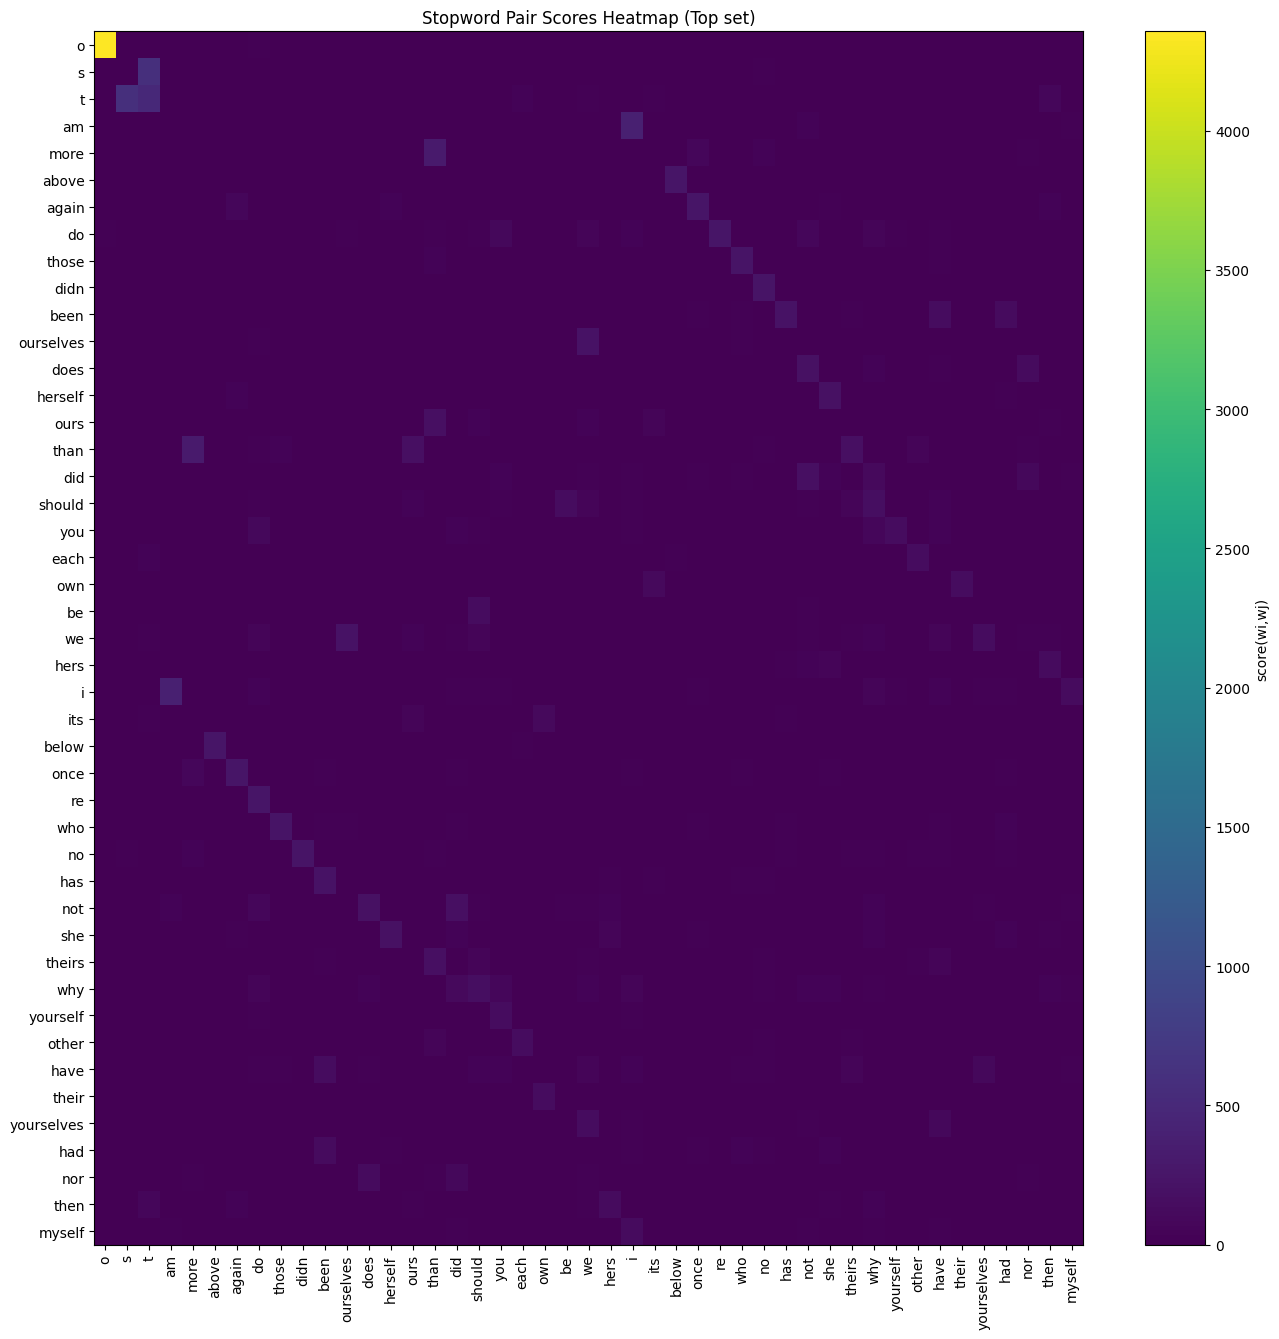

In [12]:
tableAndPlot("Brown",brown.words())

w1,w2,score
doesn,t,1946.663
shouldn,t,1945.671
t,wouldn,1909.405
didn,t,1898.344
couldn,t,1882.450
isn,t,1878.061
t,wasn,1876.765
hadn,t,1858.028
don,t,1849.909
shan,t,1845.758


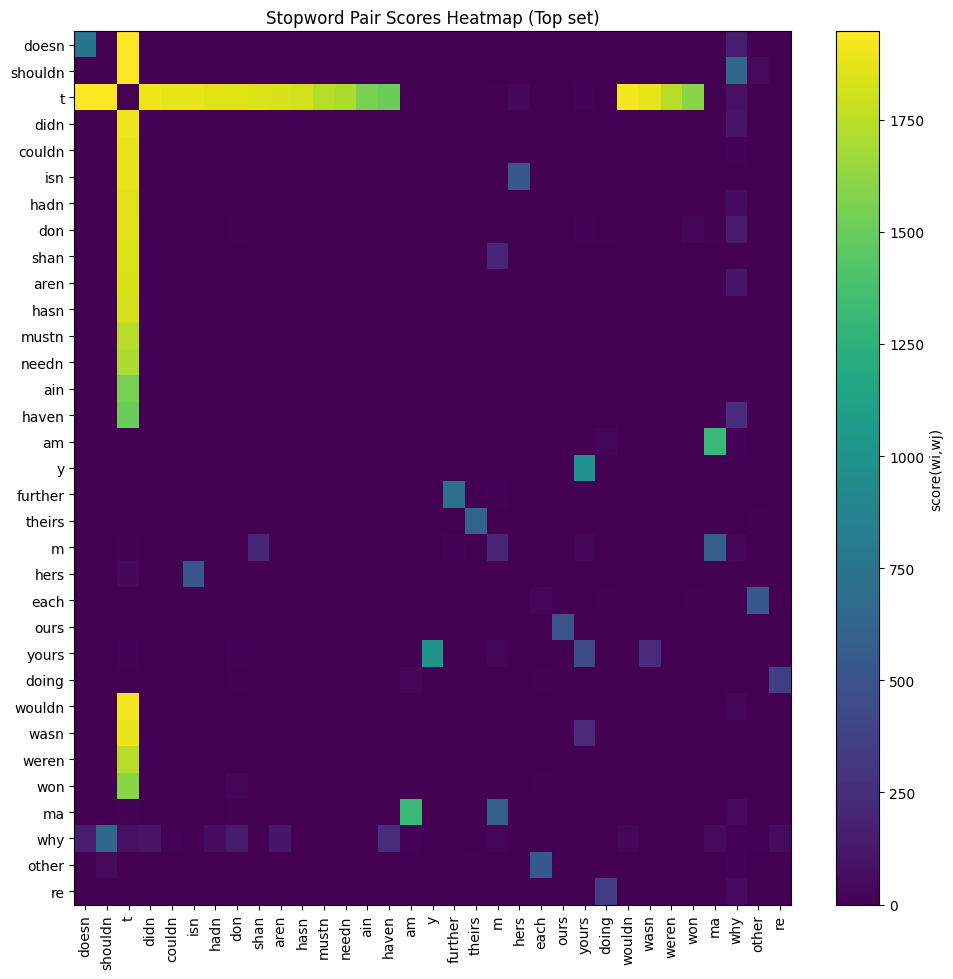

In [13]:
tableAndPlot("Gutenberg",gutenberg.words())

w1,w2,score
o,y,3855.480
yourself,yourselves,3400.611
am,ma,1646.637
its,own,844.732
such,weren,662.457
been,ve,612.933
each,other,594.980
which,whom,570.998
himself,itself,493.637
those,whom,475.241


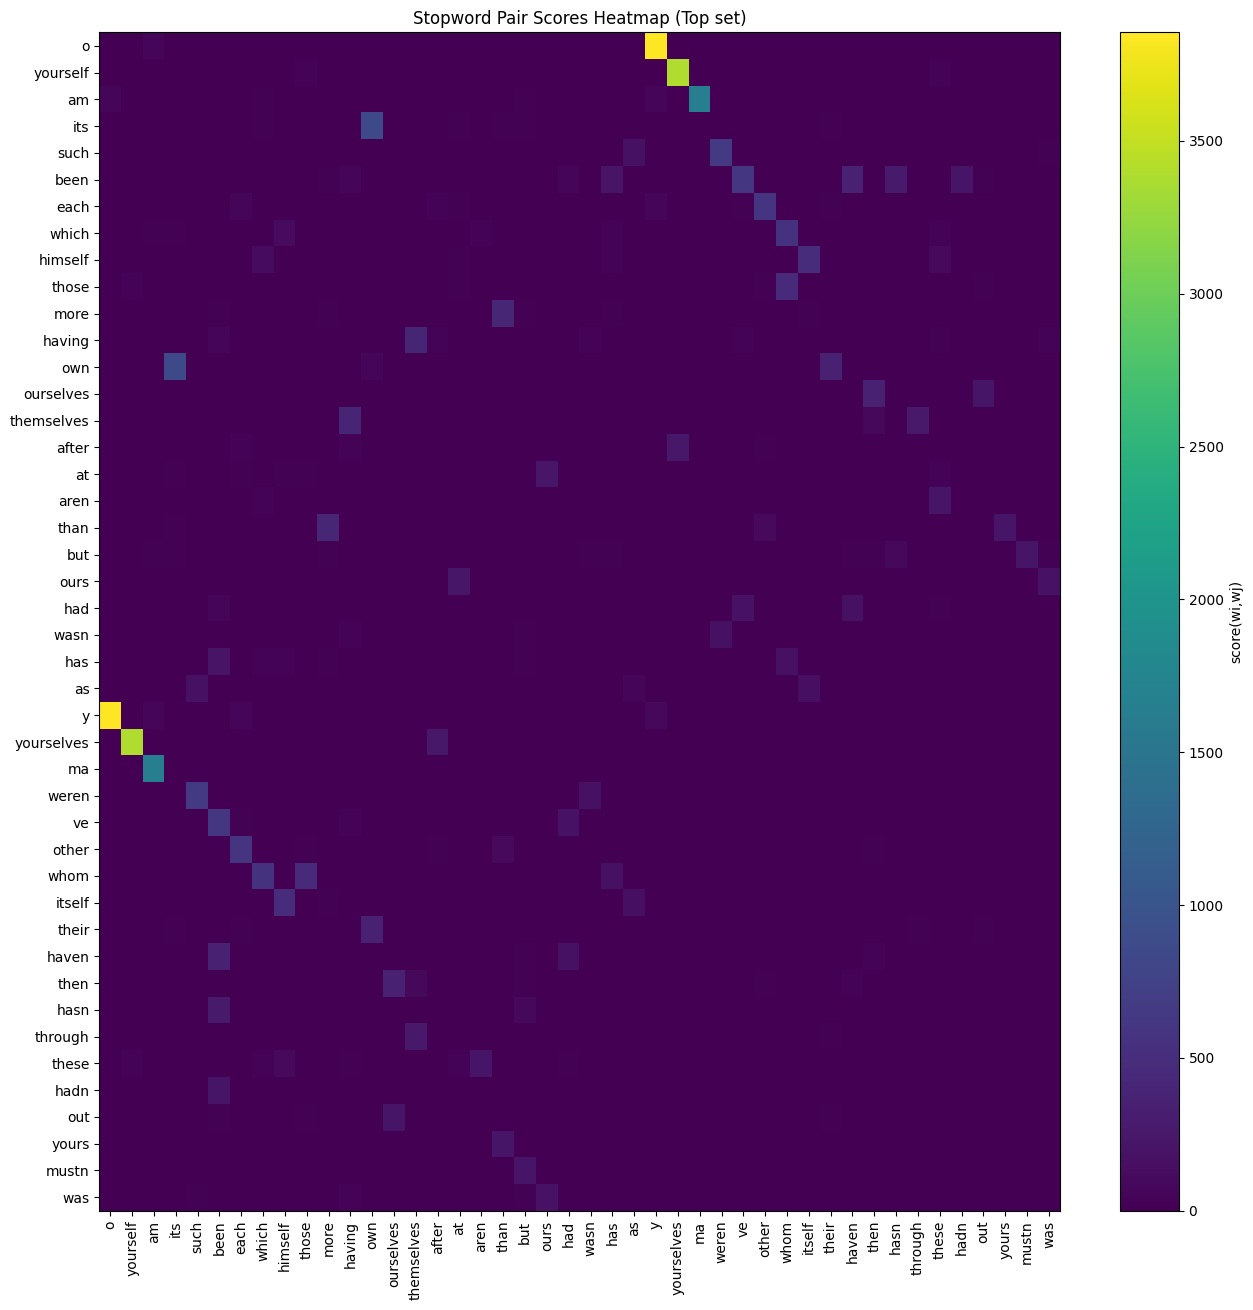

In [14]:
tableAndPlot("WebText",webtext.words())

w1,w2,score
by,himself,1714.850
each,other,1353.829
herself,over,857.425
down,under,791.469
more,than,734.936
than,yours,714.521
after,most,714.521
ll,then,418.256
been,has,408.298
few,more,408.298


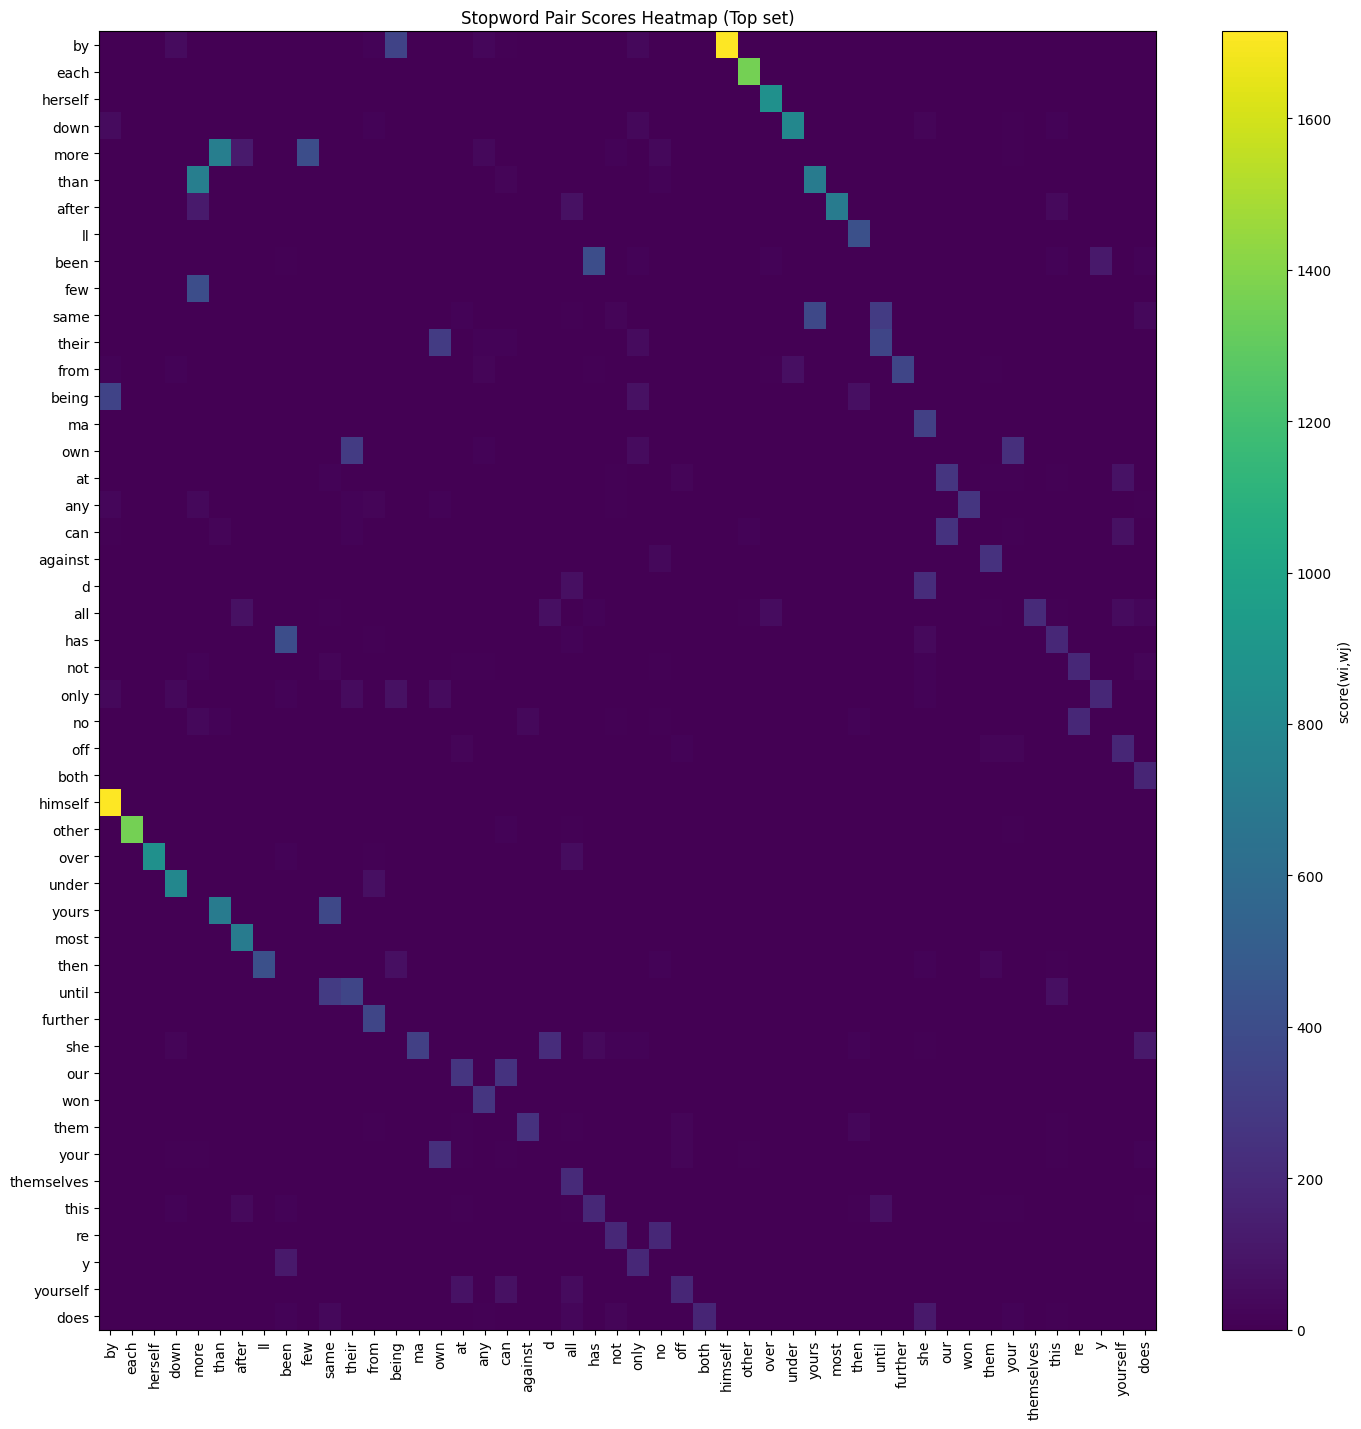

In [15]:
tableAndPlot("NPS_Chat",nps_chat.words())

w1,w2,score
ourselves,wasn,7806.712
why,yourself,7373.006
doesn,t,4345.679
didn,t,4294.631
t,wouldn,4265.256
hasn,t,4174.781
t,wasn,4174.781
aren,t,4119.850
haven,t,4094.881
don,t,4060.892


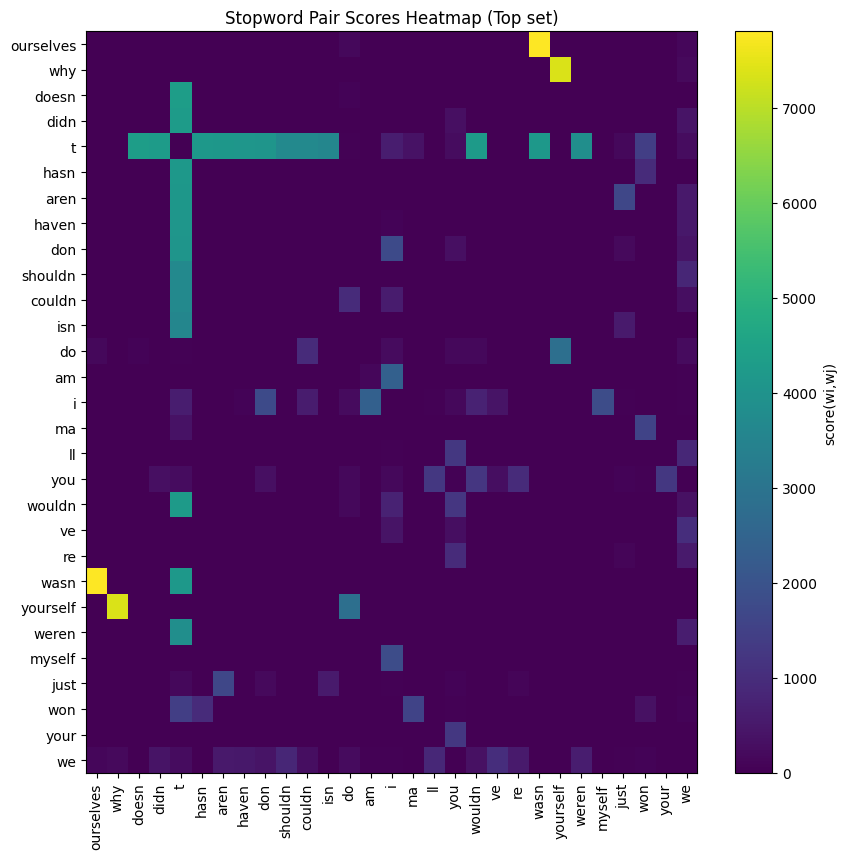

In [16]:
tableAndPlot("Reuters",reuters.words())

In [17]:
# Task 11, VADER sentiment over sentences
# Reuses from Task 1: _ensure_nltk(), tokenize_words(), get_stopwords()
# Reuse corpus_sentence_docs(name) from task 9

from nltk.sentiment import SentimentIntensityAnalyzer

try:
    nltk.data.find("sentiment/vader_lexicon")
except LookupError:
    nltk.download("vader_lexicon", quiet=True)

_ensure_nltk()
L, L_size = get_stopwords()
sia = SentimentIntensityAnalyzer()

# Parameter
Top_n = 20 # select top_n words to display in the table and plot, adjust as needed

# VADER label from sentence tokens
def vader_label(tokens: list[str]) -> str:
    text = " ".join(tokens)
    c = sia.polarity_scores(text)["compound"]
    if c >= 0.05:
        return "POS"
    elif c <= -0.05:
        return "NEG"
    else:
        return "NEU"

# Compute per-stopword polarity proportions for a corpus 
def stopword_polarity_table(docs: list[list[str]], L: set[str], min_sent_occ: int = 10) -> pd.DataFrame:
    # Precompute sentence labels
    labels = [vader_label(s) for s in docs]

    # Sentences containing each stopword 
    idx_by_word = defaultdict(list)
    for i, s in enumerate(docs):
        present = set(t for t in s if t in L)
        for w in present:
            idx_by_word[w].append(i)

    rows = []
    for w, idxs in idx_by_word.items():
        n = len(idxs)
        if n < min_sent_occ:
            continue
        lab = [labels[i] for i in idxs]
        cnt = Counter(lab)
        pos = cnt.get("POS", 0) / n
        neu = cnt.get("NEU", 0) / n
        neg = cnt.get("NEG", 0) / n
        dom = max(("POS", pos), ("NEU", neu), ("NEG", neg), key=lambda x: x[1])[0]
        pol_strength = abs(pos - neg) 
        rows.append({
            "word": w,
            "sentences_with_word": n,
            "POS_prop": pos,
            "NEU_prop": neu,
            "NEG_prop": neg,
            "dominant": dom,
            "polarization": pol_strength
        })

    df = pd.DataFrame(rows).sort_values(["polarization","sentences_with_word"], ascending=[False, False])
    df.reset_index(drop=True, inplace=True)
    return df

# Plot
def plot_polarity_stacked(df: pd.DataFrame, title: str, top_k: int = 20):
    if df.empty:
        print(f"{title}: no data to plot.")
        return
    d = df.head(top_k).copy()
    x = np.arange(len(d))
    plt.figure(figsize=(10, max(4, 0.35*len(d))))
    plt.barh(x, d["NEG_prop"], label="NEG")
    plt.barh(x, d["NEU_prop"], left=d["NEG_prop"], label="NEU")
    plt.barh(x, d["POS_prop"], left=d["NEG_prop"]+d["NEU_prop"], label="POS")
    plt.yticks(x, d["word"])
    plt.gca().invert_yaxis()
    plt.xlabel("Proportion")
    plt.title(title)
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()


# Show table and plot
def tableAPlot(name):
    docs = corpus_sentence_docs(name) # <- function from task 9                 
    df = stopword_polarity_table(docs, L, min_sent_occ=10)

    # Table
    show_table(df.head(Top_n), f"{name} — Top {Top_n} Stopword polarity proportions (rank by polarization)",
               fmt = {"POS_prop":"{:.3f}","NEU_prop":"{:.3f}","NEG_prop":"{:.3f}","polarization":"{:.3f}"}, 
               footnote = "POS = positive; NEU = neutral; NEG = negative ")
    # Plot
    plot_polarity_stacked(df, f"{name} — Top {Top_n} stopwords by polarity", top_k=Top_n)


word,sentences_with_word,POS_prop,NEU_prop,NEG_prop,dominant,polarization
won,251,0.928,0.016,0.056,POS,0.873
hers,63,0.778,0.063,0.159,POS,0.619
aren,14,0.500,0.357,0.143,POS,0.357
very,3658,0.603,0.147,0.251,POS,0.352
yours,146,0.541,0.267,0.192,POS,0.349
shouldn,18,0.556,0.222,0.222,POS,0.333
ours,60,0.567,0.200,0.233,POS,0.333
most,1411,0.598,0.132,0.270,POS,0.328
above,525,0.550,0.213,0.236,POS,0.314
having,692,0.591,0.120,0.289,POS,0.302


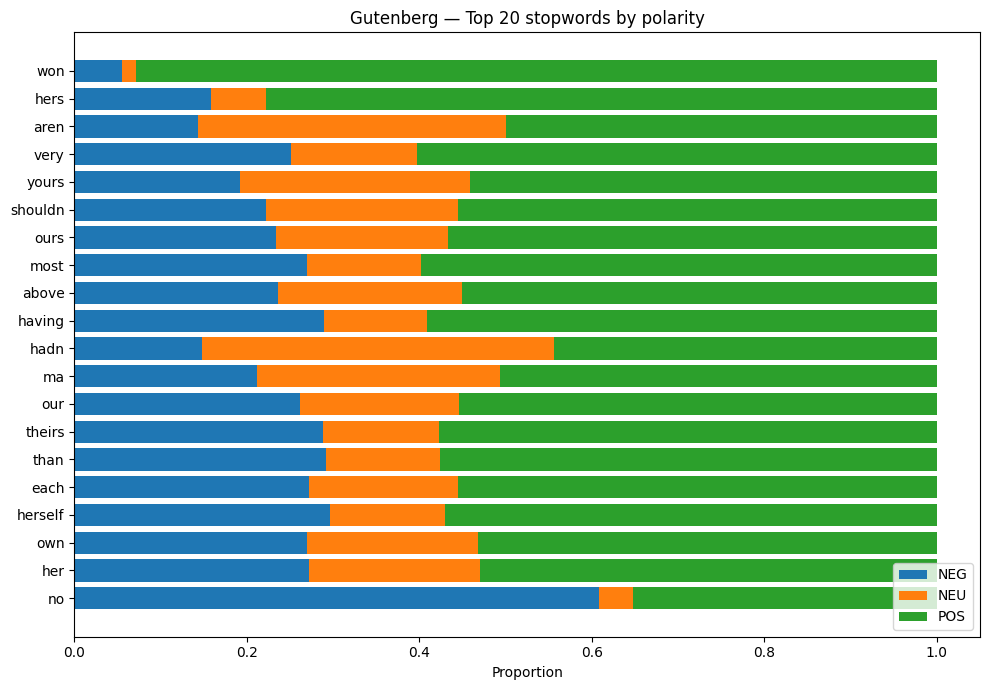

In [18]:
tableAPlot("Gutenberg")

word,sentences_with_word,POS_prop,NEU_prop,NEG_prop,dominant,polarization
itself,28,0.143,0.071,0.786,NEG,0.643
no,1341,0.169,0.028,0.802,NEG,0.633
won,171,0.772,0.012,0.216,POS,0.556
very,520,0.663,0.200,0.137,POS,0.527
below,21,0.095,0.333,0.571,NEG,0.476
each,70,0.157,0.229,0.614,NEG,0.457
himself,20,0.100,0.400,0.500,NEG,0.400
few,63,0.508,0.365,0.127,POS,0.381
y,55,0.473,0.400,0.127,POS,0.345
during,43,0.256,0.186,0.558,NEG,0.302


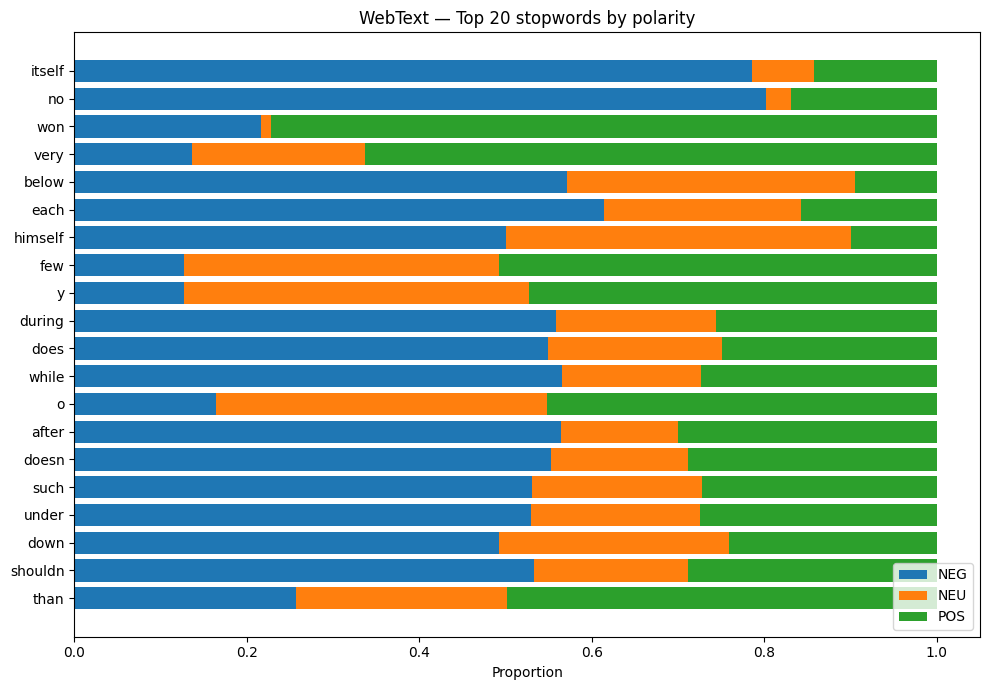

In [19]:
tableAPlot("WebText")

word,sentences_with_word,POS_prop,NEU_prop,NEG_prop,dominant,polarization
no,176,0.227,0.017,0.756,NEG,0.528
own,18,0.556,0.389,0.056,POS,0.500
before,13,0.538,0.385,0.077,POS,0.462
having,11,0.545,0.364,0.091,POS,0.455
very,20,0.550,0.350,0.100,POS,0.450
doing,23,0.435,0.522,0.043,NEU,0.391
been,56,0.518,0.339,0.143,POS,0.375
into,11,0.455,0.455,0.091,POS,0.364
their,14,0.500,0.357,0.143,POS,0.357
has,42,0.476,0.405,0.119,POS,0.357


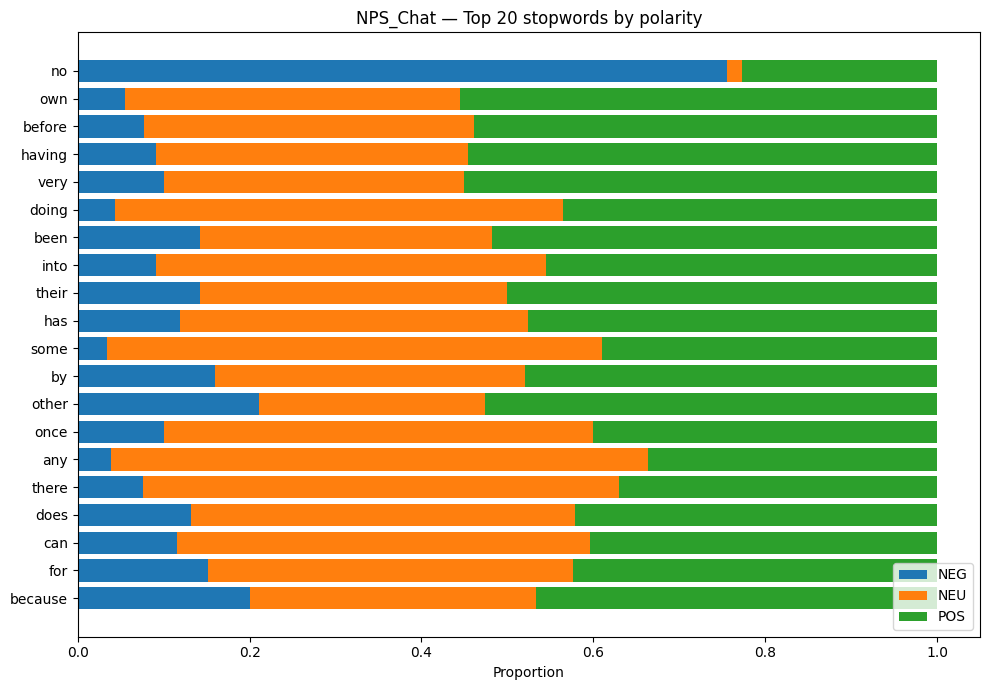

In [20]:
tableAPlot("NPS_Chat")